In [4]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import pydensecrf.densecrf as dcrf
from tqdm import tqdm
from pydensecrf.utils import unary_from_softmax

In [6]:
root = "/media/yesindeed/DATADRIVE1/data/CUB-200-2011"

df_train = pd.read_csv(os.path.join(root, "train.txt"), sep=" ", header=None, names=["img_id", "path"])
# df_val = pd.read_csv(os.path.join(root, "val.txt"), sep=" ", header=None, names=["img_id", "path"])
df_test = pd.read_csv(os.path.join(root, "test.txt"), sep=" ", header=None, names=["img_id", "path"])
df_images = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
df_images

,img_id,path
0,6564,113.Baird_Sparrow/Baird_Sparrow_0051_787319.jpg
1,6565,113.Baird_Sparrow/Baird_Sparrow_0035_106904.jpg
2,6566,113.Baird_Sparrow/Baird_Sparrow_0008_106929.jpg
3,6567,113.Baird_Sparrow/Baird_Sparrow_0014_794549.jpg
4,6568,113.Baird_Sparrow/Baird_Sparrow_0002_794551.jpg
...,...,...
3138,10697,182.Yellow_Warbler/Yellow_Warbler_0063_176800.jpg
3139,10698,182.Yellow_Warbler/Yellow_Warbler_0083_176292.jpg
3140,10710,182.Yellow_Warbler/Yellow_Warbler_0087_176591.jpg
3141,10713,182.Yellow_Warbler/Yellow_Warbler_0105_176849.jpg


In [7]:
def crf_inference(img, probs, t=10, scale_factor=1, compat=1.5):
    h, w = probs.shape

    probs = probs[None, :, :]
    probs = np.concatenate([1 - probs, probs], axis=0)

    d = dcrf.DenseCRF2D(w, h, 2)
    # unary = fake_prob.reshape((2, -1))
    unary = unary_from_softmax(probs)
    # unary = np.ascontiguousarray(unary)

    d.setUnaryEnergy(unary)
    # d.addPairwiseGaussian(3/scale_factor, compat=10)
    d.addPairwiseBilateral(sxy=80/scale_factor, srgb=13, rgbim=np.copy(img), compat=compat)

    Q = d.inference(t)
    # crf = np.argmax(Q, axis=0).reshape((h, w))
    crf = np.array(Q)[1].reshape((h, w))

    return crf

In [8]:
scale_factor = 1
t = 10
compat= 1

target = 40

for i, path in tqdm(enumerate(df_images["path"].tolist())):
    if i != target:
        continue
    img = np.array(Image.open(os.path.join(root, "images", path)).convert("RGB"))
    gazemap = np.load(os.path.join(root, "gaze", "heatmap", path.replace(".jpg", ".npy"))).astype(np.float32)

    crf_map = crf_inference(img, gazemap, t=t, scale_factor=1, compat=compat)
    save_folder = os.path.join(root, "gaze", f"crf_compat{compat}", path.split("/")[0])
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    
    np.save(os.path.join(save_folder, path.split("/")[1].replace(".jpg", ".npy")), crf_map.astype(np.float16))

3143it [00:00, 12556.25it/s]


In [57]:
# get dataset prior
priors = []
for i, path in tqdm(enumerate(df_images["path"].tolist())):
    label = np.array(Image.open(os.path.join(root, "segmentations", path.replace(".jpg", ".png"))))
    label = label.astype(np.float32) / 255.0
    mask = ((label < 0.3) | (label > 0.8))

    prior = np.sum(label * mask) / np.sum(mask)
    # print(prior)

    if prior == 0:
        break

    priors.append(prior)

print(np.mean(priors))

3143it [00:05, 609.91it/s]

0.10830802094062196


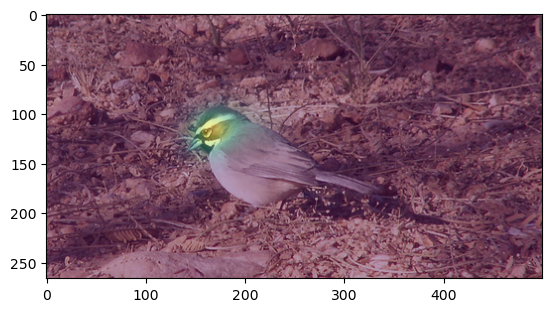

In [9]:
plt.imshow(img)
plt.imshow(crf_map, alpha=0.4)

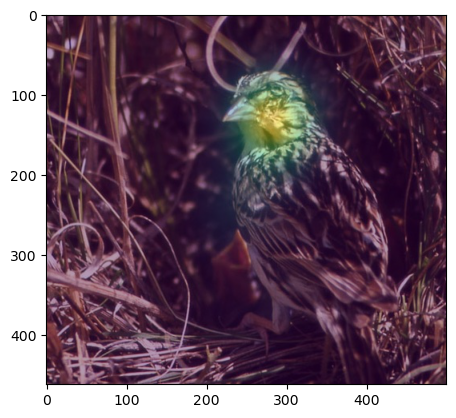

In [235]:
plt.imshow(img)
plt.imshow(gazemap, alpha=0.4)

0.7866


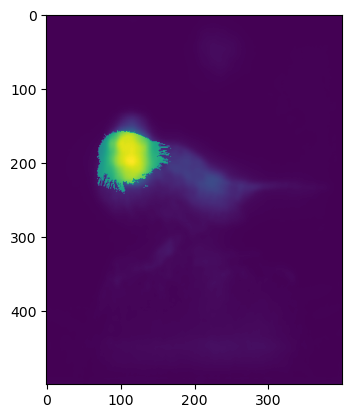

In [58]:
id = "129.Song_Sparrow/Song_Sparrow_0034_121255"

file = f"/media/yesindeed/DATADRIVE1/data/CUB-200-2011/gaze/cyclic_masks/latest/{id}.npy"
img = Image.open(os.path.join(root, "images", f"{id}.jpg"))
pseudo_mask = np.load(os.path.join(root, "gaze", "crf_compat1", f"{id}.npy"))

array = np.load(file)
print(array.max())

plt.imshow(array)

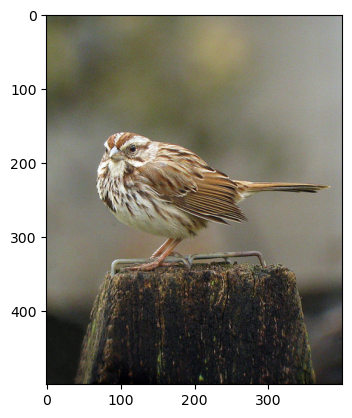

In [59]:
plt.imshow(img)

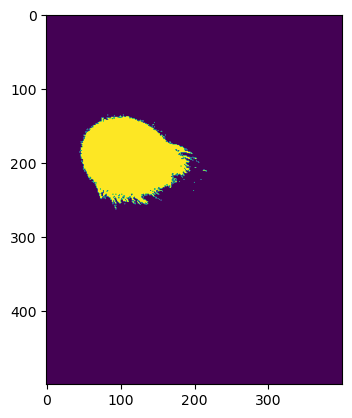

In [60]:
plt.imshow(pseudo_mask>0.2)